In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.interpolate as inter
idx = pd.IndexSlice
pyo.init_notebook_mode()


root_folder = r"C:\Users\jamen\Google Drive\Everything\Results\P1 Model\OvenMeshIndy\\"
meshes = [["Mesh0",0,60,1],["Mesh1",0,60,1],["Mesh2",0,60,1],["Mesh3",0,60,1],["Mesh4",0,60,1]] # name, first timestep, final timestep, timestep
areas = ["Food","Inlet","Outlet","Walls"] # prefix for each filename

In [3]:
# read all data into the workbook
alldata = pd.read_feather(root_folder+"alldata.feather")

In [4]:
# create a dataframe for all meshes containing the mean values on the food for each time step
food_means=alldata[alldata['area']=="Food"].groupby(["mesh","area","time"]).mean()
food_means.reset_index(inplace=True)

In [5]:
# plot average flux vs time for each mesh
px.line(food_means,x="time",y="flux",color="mesh")

The above plot is used to decide when the simulation has reached steady state, this is taken as 15 seconds and used to filter out the transient part of the data below

In [7]:
alldata = alldata[alldata['time']>15]
food_means = food_means[food_means['time']>15]

Plotting the number of elements in the mesh vs the average flux into the food over the steady state part of the simulation

In [8]:
mesh_mean = food_means.groupby(['mesh']).mean()
px.scatter(mesh_mean,x="elements",y="flux")

Create a new dataframe for contour plots of average flux over the steady state part of the sim onto the food target. 

In [9]:
contour_dfs = []
for mesh in meshes:
    mesh_df = alldata[(alldata['area']=="Food") & (alldata['mesh']==mesh[0])].groupby(['x','y','z']).mean()
    mesh_df.reset_index(inplace=True)
    mesh_df['mesh'] = mesh[0]
    contour_dfs.append(mesh_df)
contour_df = pd.concat(contour_dfs)
contour_df.reset_index(inplace=True)

Plot flux contour for each mesh

<IPython.core.display.Javascript object>


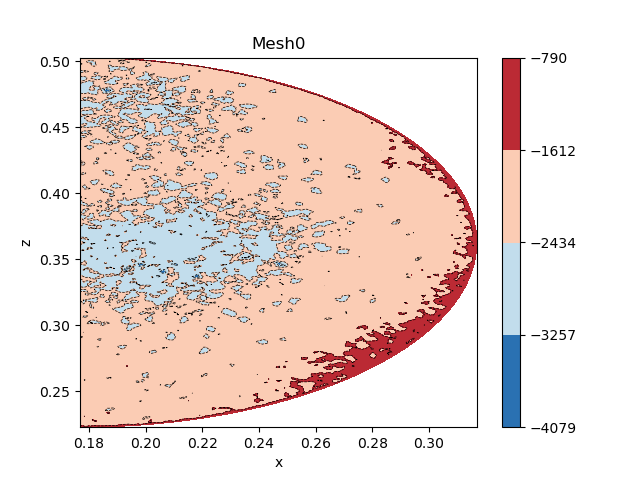

<IPython.core.display.Javascript object>


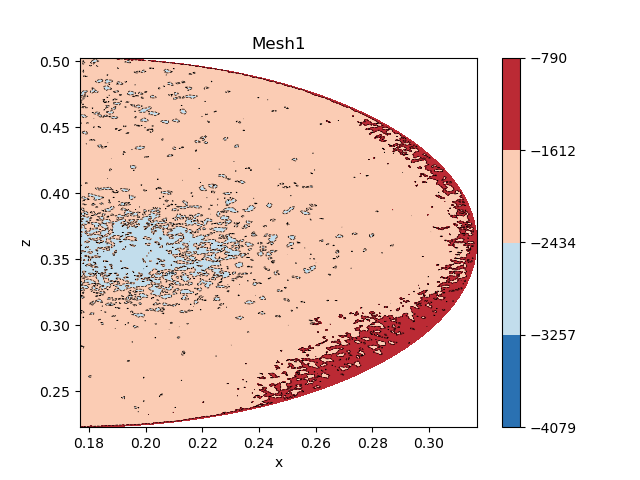

<IPython.core.display.Javascript object>


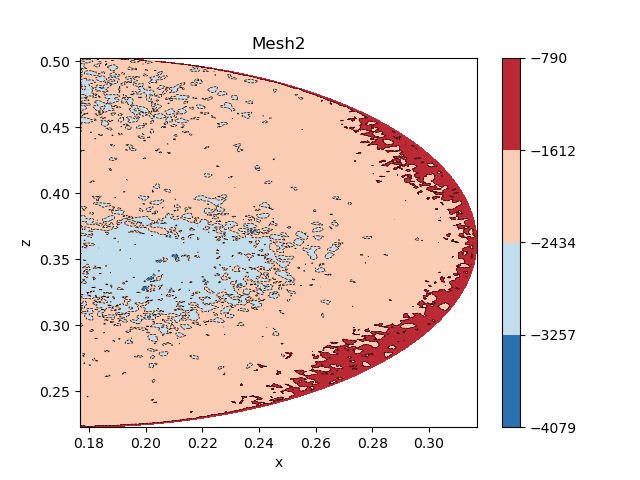

<IPython.core.display.Javascript object>


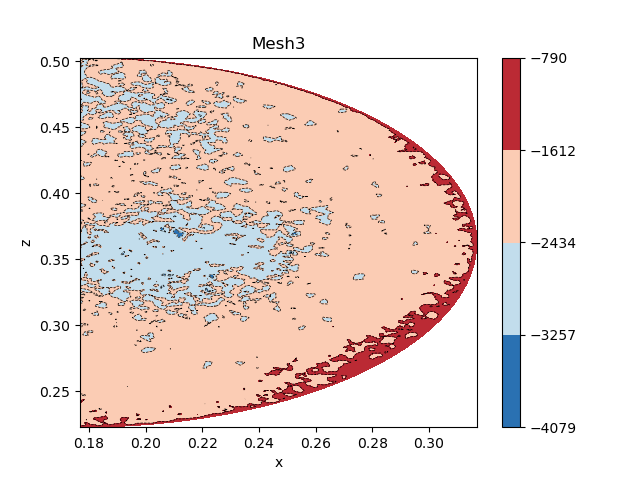

<IPython.core.display.Javascript object>


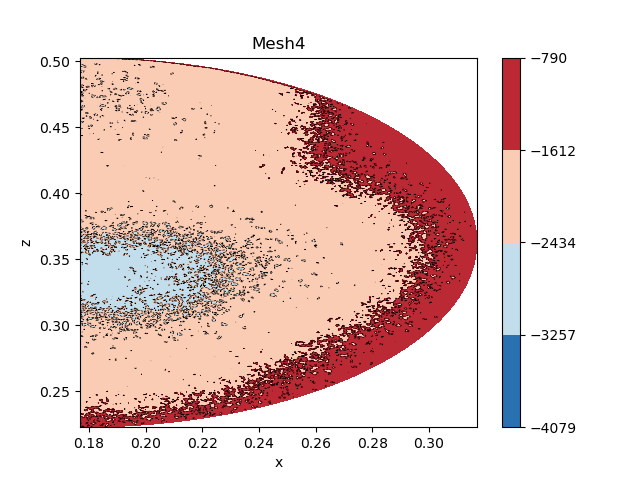

In [10]:
%matplotlib nbagg

figs = []

level_num = 5
levels = np.linspace(min(contour_df['flux']),max(contour_df['flux']),level_num)

for i in range(len(meshes)):
    figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]
    mesh = meshes[i]
    plot_df = contour_df[contour_df['mesh'] == mesh[0]]

    x = plot_df['x']
    y = plot_df['z']
    #z = df_combi[' Wall Heat Flux [ W m^-2 ]']
    z = plot_df['flux']

    ax.tricontour(x, y, z, linewidths=0.5, colors='k',levels=levels)
    cntr1 = ax.tricontourf(x, y, z, cmap="RdBu_r", levels=levels)
    fig.colorbar(cntr1, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(mesh[0])
plt.show()

To compare contours we need to put data on a common grid, to do this we interpolate the flux using scipy then project onto a common grid in a common dataframe. Creates a dataframe with x and z coordinates with the interpolated flux from each mesh.

In [18]:
resolution = 100 # number of x and y points
gridx = np.linspace(min(contour_df['x']),max(contour_df['x']),resolution)
gridz = np.linspace(min(contour_df['z']),max(contour_df['z']),resolution)

coords = []

for x in gridx:
    for z in gridz:
        coords.append([x,z])
        
interpolated_flux = pd.DataFrame({'x':[coord[0] for coord in coords],'z':[coord[1] for coord in coords]})

for i in range(len(meshes)): 
    mesh=meshes[i]
    calc_df = contour_df[contour_df['mesh'] == mesh[0]]
    cat_coord = list(zip(calc_df['x'],calc_df['z']))
    interpolator = inter.LinearNDInterpolator(cat_coord, calc_df['flux'],fill_value=0)
    interpolated_flux[mesh[0]] = interpolator(coords)

<IPython.core.display.Javascript object>


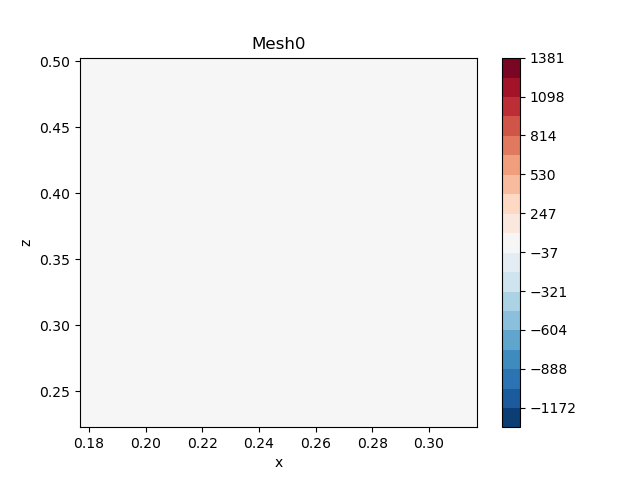

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: UserWarning:

No contour levels were found within the data range.



<IPython.core.display.Javascript object>


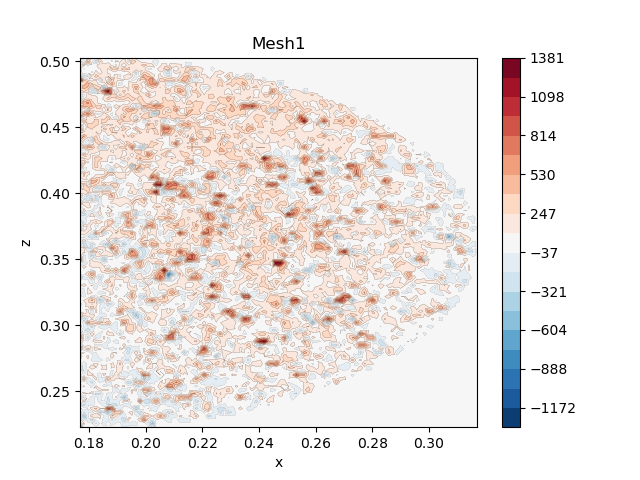

<IPython.core.display.Javascript object>


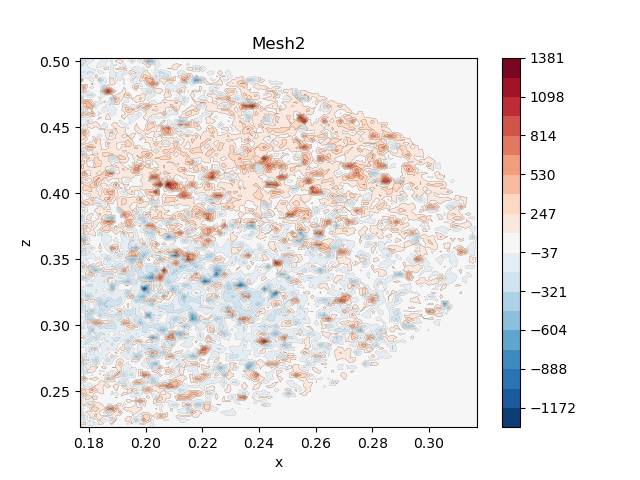

<IPython.core.display.Javascript object>


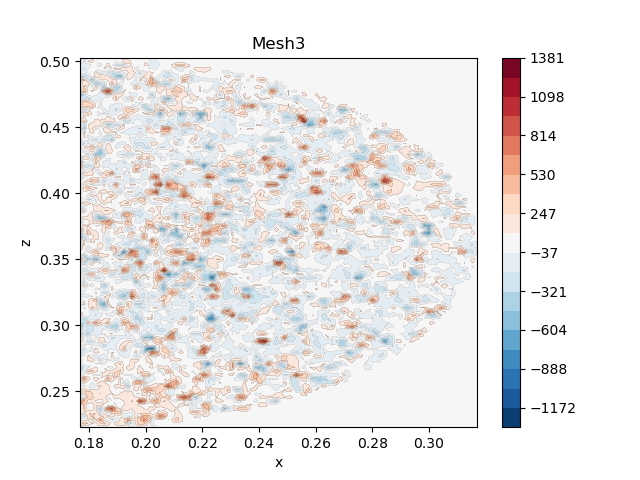

<IPython.core.display.Javascript object>


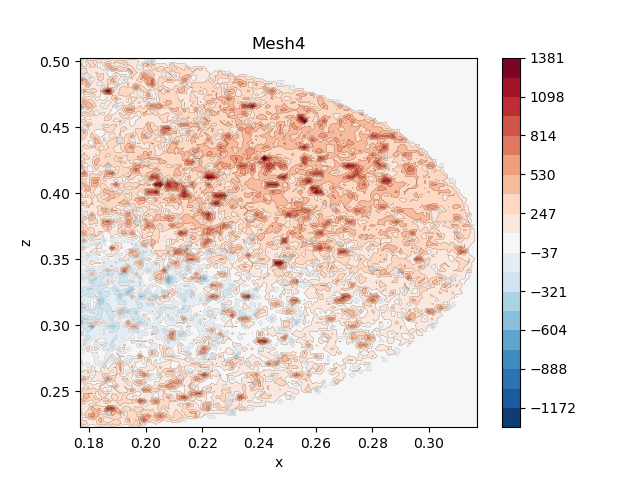

In [21]:
%matplotlib nbagg

level_num = 20

mins = []
maxs= []

for i in range(len(meshes)):
    mesh = meshes[i]
    interpolated_flux[mesh[0]+"diff"] = interpolated_flux[mesh[0]] - interpolated_flux["Mesh0"]
    mins.append(min(interpolated_flux[mesh[0]+"diff"]))
    maxs.append(max(interpolated_flux[mesh[0]+"diff"]))

levels = np.linspace(min(mins),max(maxs),level_num)
figs = []

for i in range(len(meshes)):
    mesh = meshes[i]
    figs.append(plt.subplots(nrows=1))
    fig, ax = figs[i]

    x = interpolated_flux['x']
    y = interpolated_flux['z']
    #z = df_combi[' Wall Heat Flux [ W m^-2 ]']
    z = interpolated_flux[mesh[0]+"diff"]

    ax.tricontour(x, y, z, linewidths=0.1, colors='k',levels=levels)
    cntr1 = ax.tricontourf(x, y, z, cmap="RdBu_r", levels=levels)
    fig.colorbar(cntr1, ax=ax)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_title(mesh[0])
plt.show()

In [15]:
interpolated_flux

x         z        Mesh0        Mesh1        Mesh2        Mesh3  \
0     0.176841  0.222841  -984.604356 -1777.909935 -1222.473440 -1116.040155   
1     0.176841  0.225669 -1896.122561 -1760.572854 -1690.029709 -1695.995602   
2     0.176841  0.228497 -1885.535949 -1710.767810 -1972.295977 -1872.817103   
3     0.176841  0.231325 -2010.897667 -1898.999350 -1810.789382 -1917.377374   
4     0.176841  0.234154 -2119.260968 -2135.179015 -1848.500972 -1903.168861   
...        ...       ...          ...          ...          ...          ...   
9995  0.316841  0.491528          NaN          NaN          NaN          NaN   
9996  0.316841  0.494356          NaN          NaN          NaN          NaN   
9997  0.316841  0.497184          NaN          NaN          NaN          NaN   
9998  0.316841  0.500012          NaN          NaN          NaN          NaN   
9999  0.316841  0.502841          NaN          NaN          NaN          NaN   

            Mesh4  Mesh0diff   Mesh1diff   Mesh2diff   Mesh3diff   Mesh4diff  
0    -1179.532824        0.0 -793.305578 -237.869084 -131.435799 -194.928468  
1    -1641.213577        0.0  135.549707  206.092852  200.126959  254.908984  
2    -1631.696291        0.0  174.768138  -86.760028   12.718846  253.839658  
3    -1717.599257        0.0  111.898317  200.108285   93.520293  293.298410  
4    -1774.048846        0.0  -15.918047  270.759996  216.092107  345.212122  
...           ...        ...         ...         ...         ...         ...  
9995          NaN        NaN         NaN         NaN         NaN         NaN  
9996          NaN        NaN         NaN         NaN         NaN         NaN  
9997          NaN        NaN         NaN         NaN         NaN         NaN  
9998          NaN        NaN         NaN         NaN         NaN         NaN  
9999          NaN        NaN         NaN         NaN         NaN         NaN  

[10000 rows x 12 columns]